# Plot DA-ACh synapse simulation

In [1]:
%cd Experiment-Simulation/

/home/jofrony/Documents/Repositories/BasalGangliaExperiments/Neuromodulation-software/local/adaptive/Experiment-Simulation


In [2]:
from project_wide.compare_plot_traces import comparePlotTraces
from project_wide.compare_activity_analyse import compareTraces

In [3]:
def plot_dopamine_control(obj_loaded_traces,type_cell=None,traces=10,sub_dir=None,skip=50):
    
    import matplotlib.pyplot as plt
    import numpy as np
        
    data_dict = obj_loaded_traces.get_traces(neuronType=type_cell)
    
    control = np.array([*data_dict[0].values()])
    da = np.array([*data_dict[1].values()])
    
    control_m = np.mean(control,axis=0)
    control_std = np.std(control,axis=0)
    
    da_m = np.mean(da,axis=0)
    da_std = np.std(da,axis=0)
    
    legend_font = {'family' : 'Arial', 'weight' : 'normal', 'size': 12}
    
    
    for i in np.arange(1,len(control),int(len(control)/traces)):
            fig = plt.figure()           
            ax = fig.add_subplot(111)
            time = np.arange(0,len(control[i])*0.5,0.5)[int(50/0.5):]
            ax.plot(time,control[i][int(50/0.5):]*1e3,c='black')
            ax.plot(time,da[i][int(50/0.5):]*1e3,c='red')
            ax.set_ylabel('Membrane potential (mV)', fontdict=legend_font)
            ax.set_xlabel('Time(ms)', fontdict=legend_font)
            
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.yaxis.set_ticks_position('left')
            ax.xaxis.set_ticks_position('bottom')
            ax.plot(np.arange(2500,3000),np.ones_like(np.arange(2500,3000))*-75,c='black')
            ax.text(2500,-74,'500 ms',fontdict=legend_font)

            if max(da[i])>0:
                ax.set_ylim([-110,40])
                ax.plot(2500*np.ones_like(np.arange(-60,-40)),np.arange(-60,-40),c='black')
                ax.text(2550,-40,'20 mV',fontdict=legend_font)
            else:
                ax.set_ylim([-110,-50])
                ax.plot(2500*np.ones_like(np.arange(-80,-75)),np.arange(-80,-75),c='black')
                ax.text(2550,-78,'5 mV',fontdict=legend_font)
                
            ylocs, labels = plt.yticks()
            xlocs, labels = plt.xticks()
            ylocs = [int(k) for k in ylocs]
            xlocs = [int(k) for k in xlocs]
            ax.set_xticklabels(labels=xlocs,fontdict=legend_font)
            ax.set_yticklabels(labels=ylocs,fontdict=legend_font)
            fig.savefig('/'.join(['adaptive',sub_dir,'dopamine-control-traces-'+str(i)+'-'+type_cell+".svg"]))
            
    plt.show()

In [4]:
import elephant as elp
import neo
import quantities as pq
import numpy as np
import matplotlib.pyplot as plt

def firing_frequency(obj_loaded_traces,type_cell='dSPN'):

    data = obj_loaded_traces.get_traces(neuronType=type_cell)
    data_spikes = dict()
    data_average = dict()
    for ctr, network in data.items():
        data_spikes.update({ctr : dict()})
        data_average.update({ctr : dict()})
        for k, volt in network.items():
            neov = neo.AnalogSignal(volt, units='V',sampling_period = 5e-4 * pq.s)
            spike = elp.spike_train_generation.threshold_detection(neov)
            data_spikes[ctr].update({k : spike})
            
            if len(spike) >0:
                print(max(volt[4000:5000]))
                av = elp.statistics.mean_firing_rate(spike,t_start=2 * pq.s, t_stop= 2.5 *pq.s)
                
                data_average[ctr].update({k : av})
            
    return data_spikes, data_average

def plot_mean_frequency(data_average,labels_v=['V0', 'V1'],exp_title=None,color=['black','red']):
    
    legend_font = {'family' : 'Arial', 'weight' : 'normal', 'size': 12}
    fig, ax = plt.subplots()
    pos = 0
    for k, average in data_average.items():
        ax.bar([pos], [np.array([*average.values()]).mean()],yerr=[np.array([*average.values()]).std()],color=color[k], width=0.4,align='center',capsize=10)
        pos=pos+1
        
    ax.set_ylabel('Mean frequency (Hz)',fontdict=legend_font)
    ax.set_title('Mean frequency (Hz)',fontdict=legend_font)
    ax.set_xticks([*data_average.keys()])
    ax.set_xticklabels(labels_v,fontdict=legend_font)
    

    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    ylocs, labels = plt.yticks()
    ylocs = [int(k) for k in ylocs]
    ax.set_yticklabels(labels=ylocs,fontdict=legend_font)
    

    ax.figure.set_size_inches(2, 4)
    plt.tight_layout()
    plt.title(exp_title)
    plt.savefig('adaptive/'+exp_title+'_mean_freuquency.svg')
    plt.show()

def percentage_spike(obj_loaded_traces,type_cell='dSPN',total=None):
    
    ratio = dict()
    
    data_dict = obj_loaded_traces.get_traces(neuronType=type_cell)
    for k, data in data_dict.items():
        
        depol = 0
        spike = 0
        
        for t, voltages in data.items():
            if max(voltages)<0:
                depol=depol+1
            else:
                spike=spike+1
                
        ratio.update({k : {'spike': spike, 'pol' : depol, 'percentage': spike/total*100}})
        
    return ratio


def plot_percentage(percentages,chosen=[3,4],labels_v=['control','DA'],c=['black','red'],exp_title='dSPN'):
    fig, ax = plt.subplots()
    legend_font = {'family' : 'Arial', 'weight' : 'normal', 'size': 12}
    pos = 3
    for k, per in percentages.items():
        if k in chosen:
            ax.bar([k], [per['percentage']],align='center',capsize=10,width=0.4,color=c[k])
            
    ax.set_ylabel('Percentage spiking neurons (total) %',fontdict=legend_font)
    ax.set_title('Ratio spike/pol',fontdict=legend_font)
    ax.set_xticks(range(len(chosen)))
    ax.set_xticklabels(labels_v,fontdict=legend_font)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')


    
    ax.figure.set_size_inches(2, 4)
    plt.tight_layout()
    plt.title(exp_title)
    plt.savefig('adaptive/'+exp_title+'_precentage.svg')
    plt.show()


In [5]:
root = 'Acetylcholine-Dopamine-concACh-concDA-network/'
simroot = root + 'simulation/'
fn = [simroot + 'network-voltage-ACh-DA-network-control.csv',\
        simroot + 'network-voltage-ACh-DA-network.csv']


nf = [root + 'network-synapses.hdf5',\
      root + 'network-synapses.hdf5']


kl = compareTraces(fileNames=fn,\
                      networkFiles=nf,labels=['control','DA'],colours=['black', 'red'])



Unable to guess ID, using 666.
Loading 29 neurons with 21504 synapses and 0 gap junctions
Loading 29 neurons with 21504 synapses and 0 gap junctions


In [6]:
from snudda.utils.load import SnuddaLoad 
loadeddata =  SnuddaLoad(root + "network-neuron-positions.hdf5")

posInfo = loadeddata.data
cellpositions = posInfo['neuronPositions']
type_n = [kion['name'] for kion in posInfo['neurons']]
type_n

['DopaminergicAxon_0',
 'dSPN_0',
 'DopaminergicAxon_0',
 'dSPN_2',
 'DopaminergicAxon_0',
 'DopaminergicAxon_0',
 'dSPN_1',
 'dSPN_0',
 'dSPN_1',
 'dSPN_2',
 'dSPN_1',
 'dSPN_0',
 'dSPN_0',
 'dSPN_1',
 'dSPN_2',
 'dSPN_1',
 'dSPN_2',
 'dSPN_2',
 'dSPN_2',
 'dSPN_0',
 'dSPN_2',
 'dSPN_0',
 'dSPN_1',
 'dSPN_1',
 'dSPN_2',
 'dSPN_2',
 'dSPN_1',
 'dSPN_0',
 'dSPN_0']

/home/jofrony/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
/home/jofrony/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/jofrony/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/jofrony/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/jofrony/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/jofrony/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedF

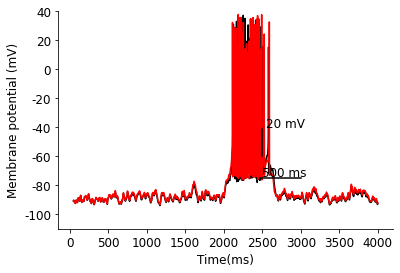

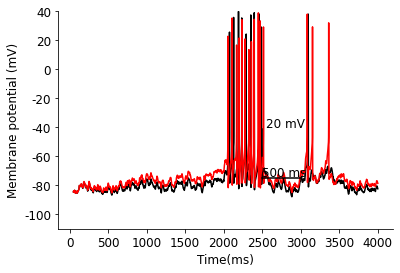

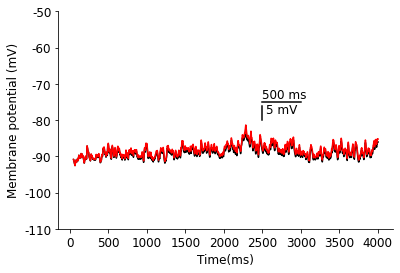

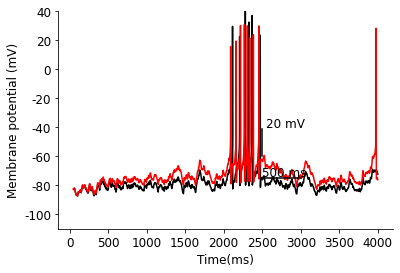

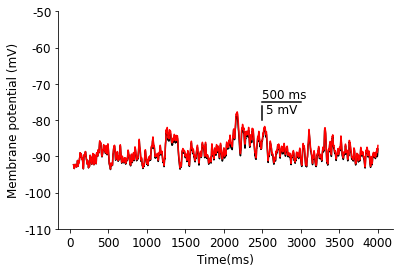

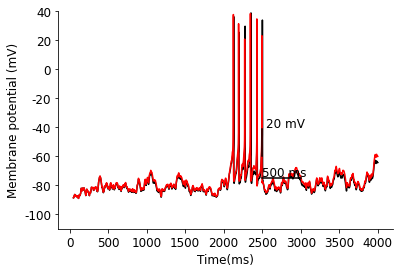

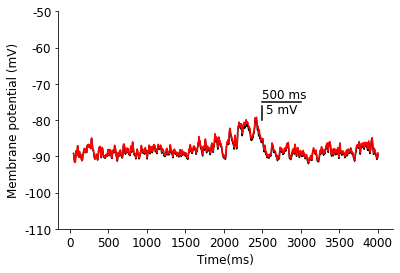

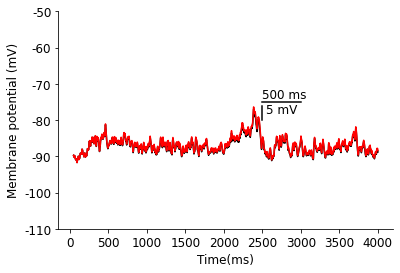

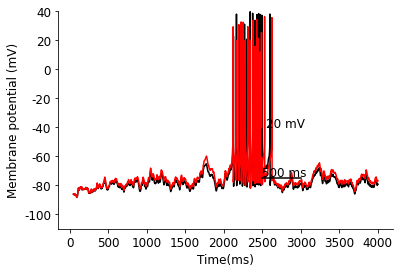

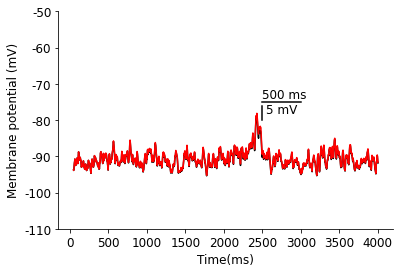

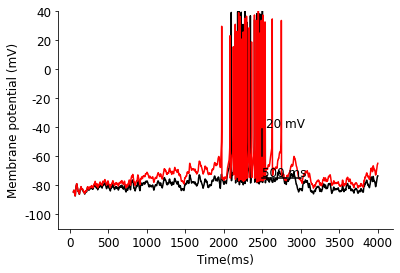

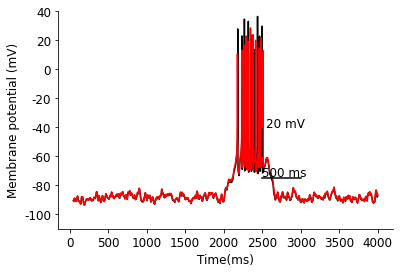

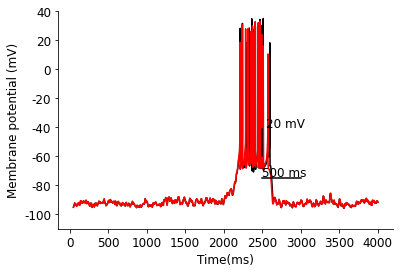

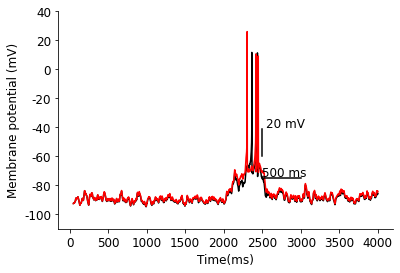

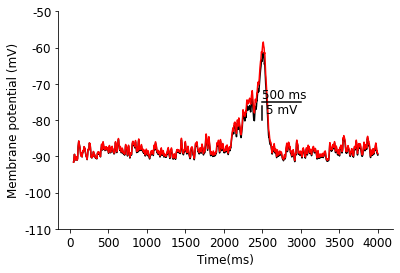

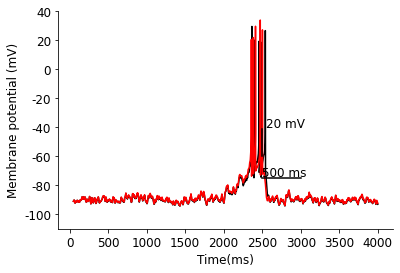

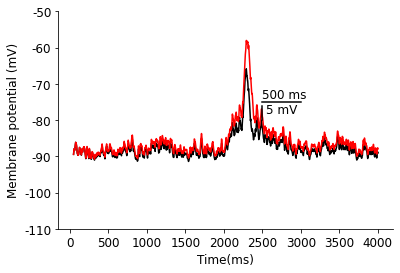

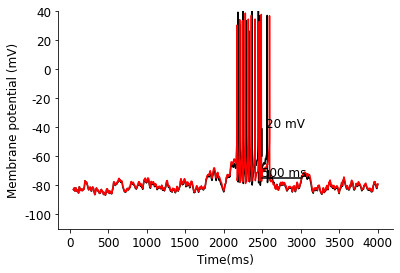

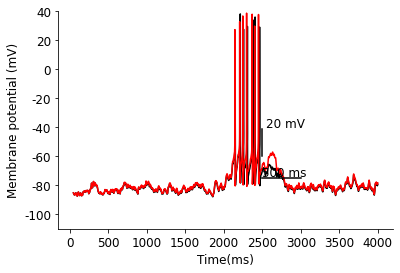

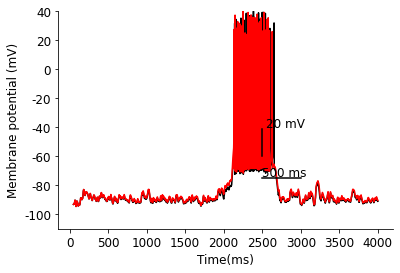

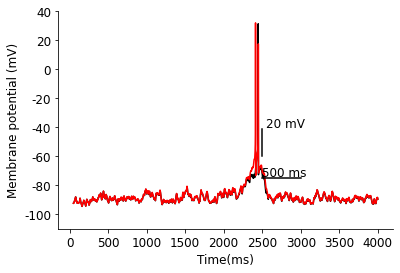

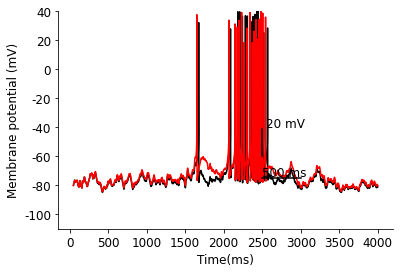

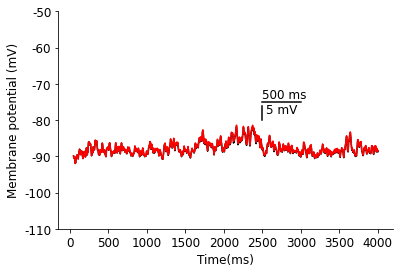

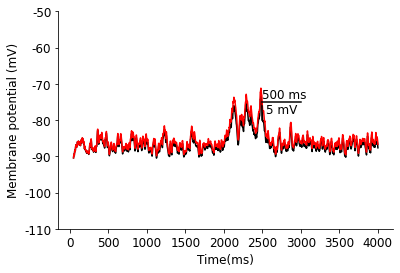

In [7]:
plot_dopamine_control(kl,type_cell='dSPN',traces=20,sub_dir='dSPN-dopamine')

/home/jofrony/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/jofrony/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/jofrony/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator


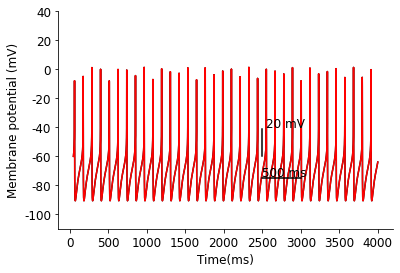

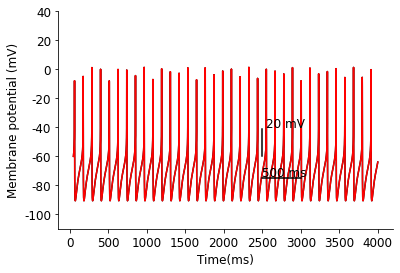

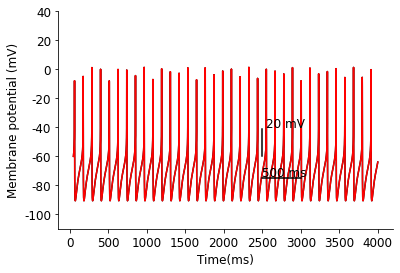

In [8]:
plot_dopamine_control(kl,type_cell='DopaminergicAxon',traces=4,sub_dir='dSPN-dopamine')

0.037253100000000004
0.039913800000000006
0.0413548
0.0388921
0.0397318
0.0416624
0.0364969
0.034891599999999995
0.0116762
0.0295937
0.0426265
0.038217799999999996
0.040096200000000005
0.031423
0.040319
0.0378725
0.0389516
0.030891500000000002
0.038489199999999994
0.034187800000000004
0.0404749
0.028544200000000002
0.0333039
0.0260481
0.0339968
0.038836
0.0387599
0.0415745
0.0320395
0.0399959


/home/jofrony/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator


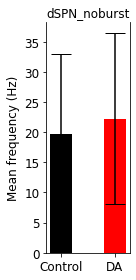

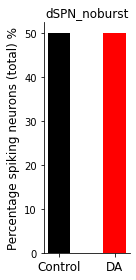

In [9]:
spikes_dSPN, average_dSPN = firing_frequency(kl,type_cell='dSPN')
plot_mean_frequency(average_dSPN,labels_v=['Control','DA'],exp_title='dSPN_noburst')
per_dSPN = percentage_spike(kl,type_cell='dSPN',total=30)
plot_percentage(per_dSPN,exp_title='dSPN_noburst',labels_v=['Control','DA'],chosen=[0,1],c=['black','red'])

In [10]:
per_dSPN

{0: {'spike': 15, 'pol': 10, 'percentage': 50.0},
 1: {'spike': 15, 'pol': 10, 'percentage': 50.0}}

In [23]:
root = 'Acetylcholine-Dopamine-concACh-concDA-network/'
simroot = root + 'simulation/'
fn = [simroot + 'network-voltage-ACh-DA-network-burst-control.csv',\
      simroot + 'network-voltage-ACh-DA-network-burst.csv']

nf = [root + 'network-synapses.hdf5',\
      root + 'network-synapses.hdf5']


kl = compareTraces(fileNames=fn,\
                      networkFiles=nf,labels=['Control', 'DA'],colours=['black','red'])



Unable to guess ID, using 666.
Loading 29 neurons with 21504 synapses and 0 gap junctions
Loading 29 neurons with 21504 synapses and 0 gap junctions


/home/jofrony/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/jofrony/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/jofrony/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/jofrony/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/jofrony/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/jofrony/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/jofrony/mi

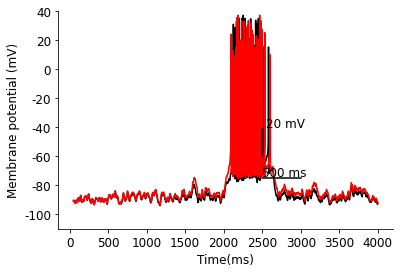

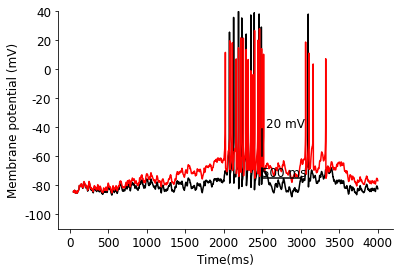

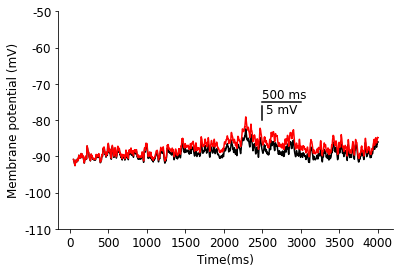

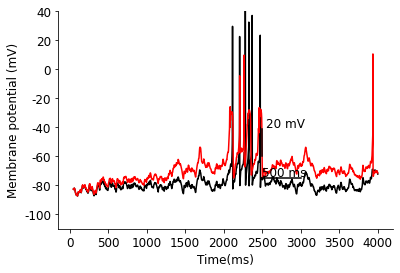

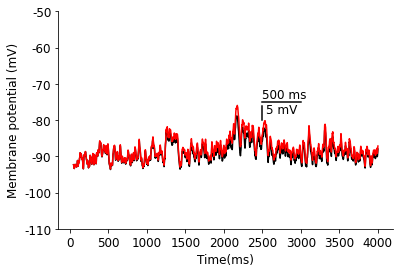

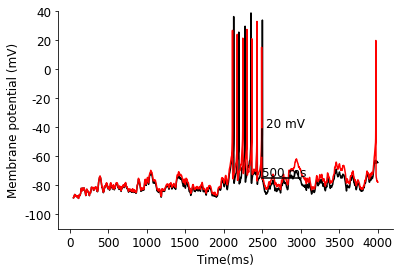

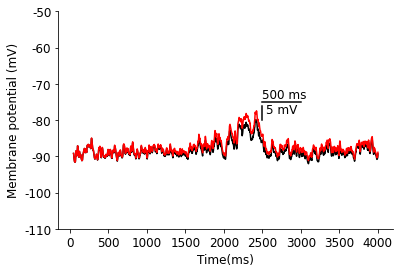

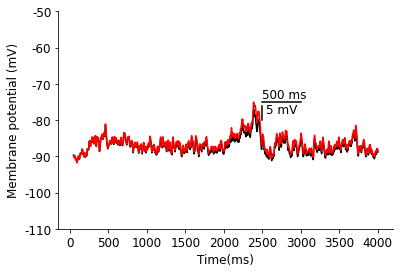

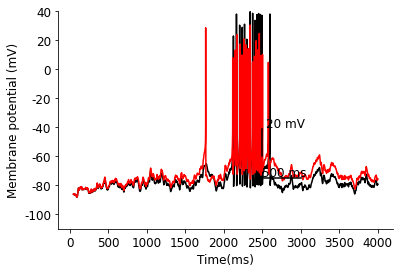

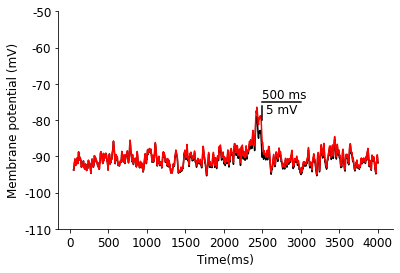

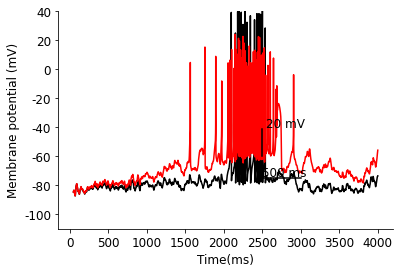

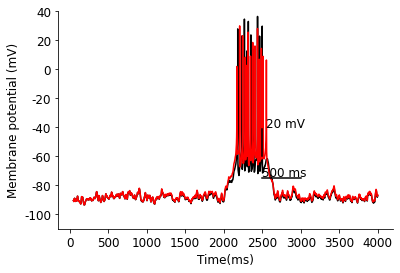

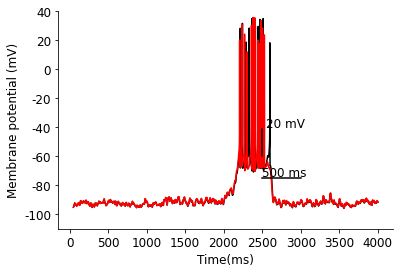

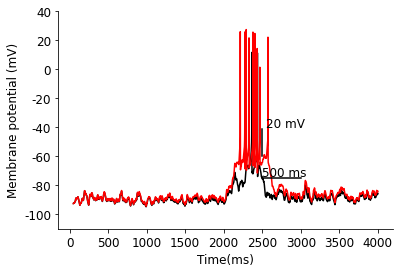

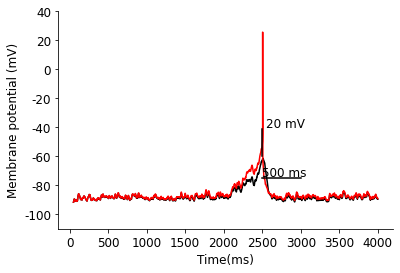

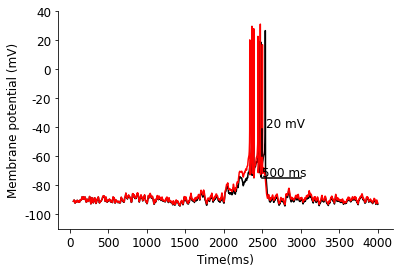

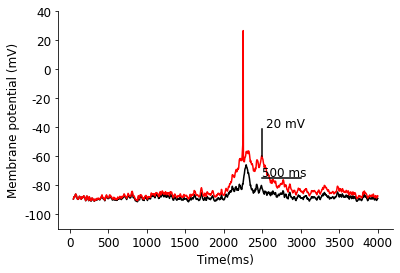

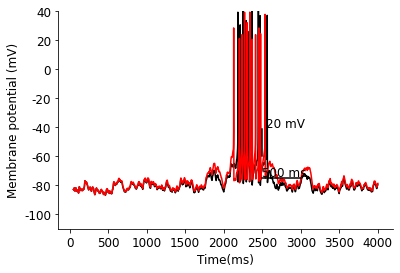

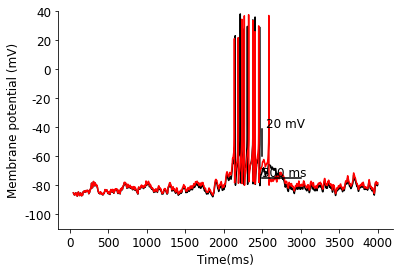

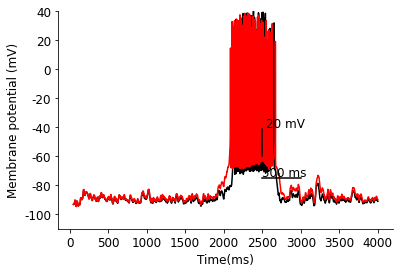

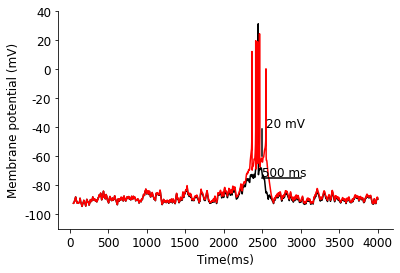

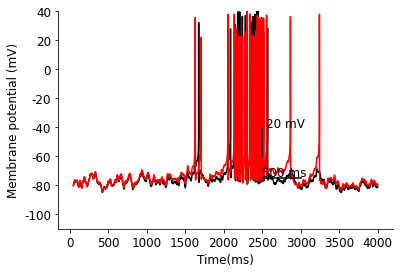

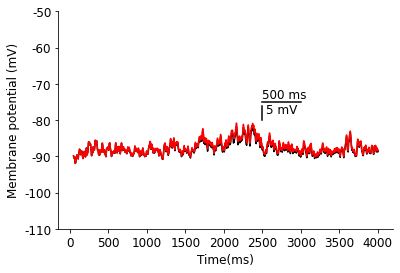

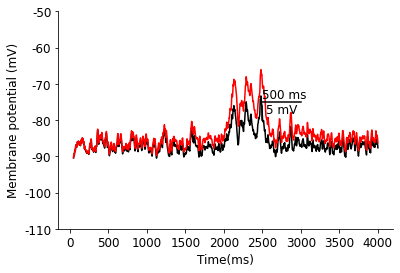

In [24]:
plot_dopamine_control(kl,type_cell='dSPN',traces=25,sub_dir='dSPN-dopamine-burst')

/home/jofrony/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/jofrony/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/jofrony/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator


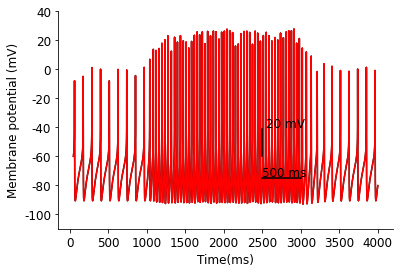

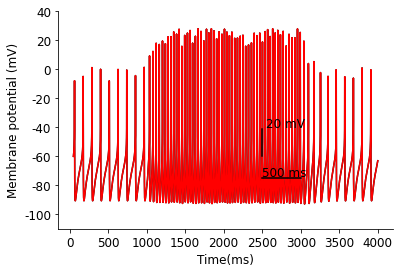

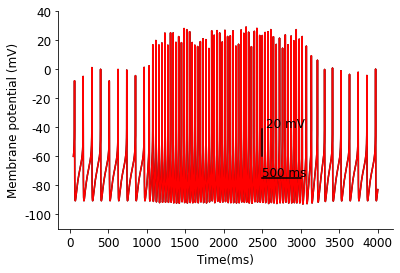

In [25]:
plot_dopamine_control(kl,type_cell='DopaminergicAxon',traces=4,sub_dir='dSPN-dopamine-burst')

0.037253100000000004
0.039913800000000006
0.0413548
0.0388921
0.0397318
0.0416624
0.0364969
0.034891599999999995
0.0116762
0.0295937
0.0426265
0.038217799999999996
0.040096200000000005
0.031423
0.040319
0.0374007
0.0279925
0.0098133
0.0330319
0.0306036
0.0241003
0.029963999999999998
0.0357549
0.027443600000000002
-0.0530614
0.031200099999999998
0.0267264
0.0394633
0.037689799999999996
0.0389541
0.0245619
0.0411714


/home/jofrony/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator


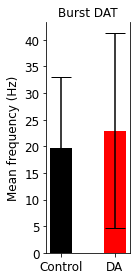

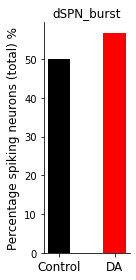

{0: {'spike': 15, 'pol': 10, 'percentage': 50.0},
 1: {'spike': 17, 'pol': 8, 'percentage': 56.666666666666664}}

In [14]:
spikes_dSPN, average_dSPN = firing_frequency(kl,type_cell='dSPN')
plot_mean_frequency(average_dSPN,labels_v=['Control','DA'],exp_title='Burst DAT')
per_dSPN = percentage_spike(kl,type_cell='dSPN',total=30)
plot_percentage(per_dSPN,exp_title='dSPN_burst',labels_v=['Control','DA'],chosen=[0,1],c=['black','red'])
per_dSPN

In [20]:
root = 'Acetylcholine-Dopamine-concACh-concDA-network/'
simroot = root + 'simulation/'
fn = [simroot + 'network-voltage-ACh-DA-network-control.csv',\
        simroot + 'network-voltage-ACh-DA-network.csv',\
      simroot + 'network-voltage-ACh-DA-network-burst-control.csv',\
      simroot + 'network-voltage-ACh-DA-network-burst.csv']

nf = [root + 'network-synapses.hdf5',\
      root + 'network-synapses.hdf5',\
      root + 'network-synapses.hdf5',\
      root + 'network-synapses.hdf5']


kl = compareTraces(fileNames=fn,\
                      networkFiles=nf,labels=['Control', 'DA', 'Control Burst', 'DA burst'],colours=['black','red','black','red'])



Unable to guess ID, using 666.
Loading 29 neurons with 21504 synapses and 0 gap junctions
Loading 29 neurons with 21504 synapses and 0 gap junctions
Loading 29 neurons with 21504 synapses and 0 gap junctions
Loading 29 neurons with 21504 synapses and 0 gap junctions


/home/jofrony/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/jofrony/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/jofrony/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/jofrony/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/jofrony/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/jofrony/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/jofrony/mi

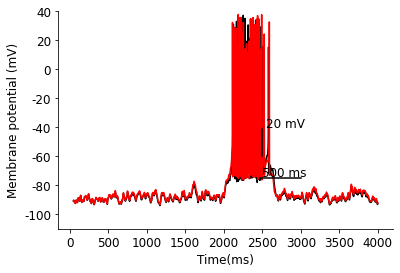

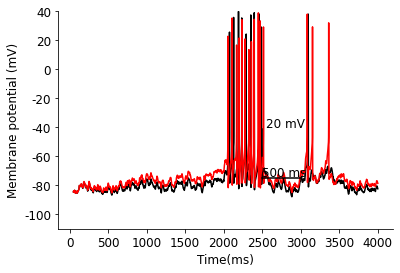

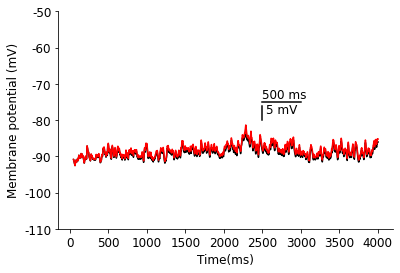

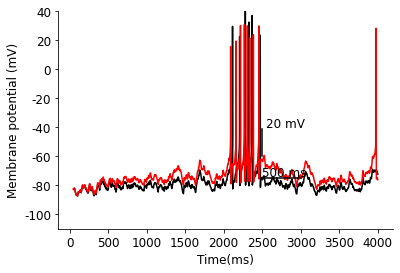

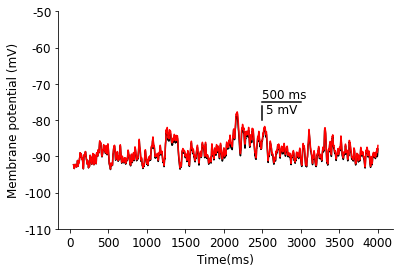

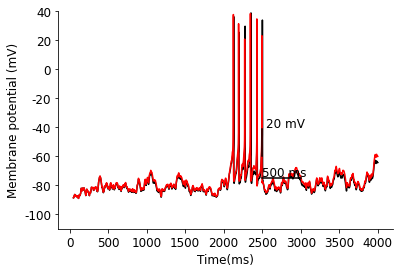

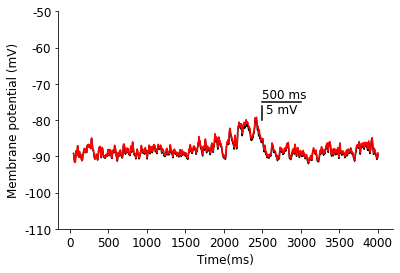

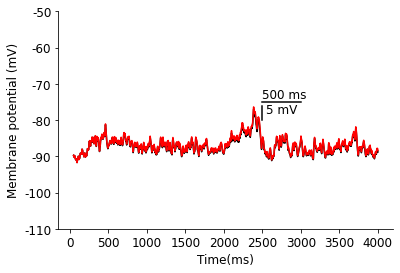

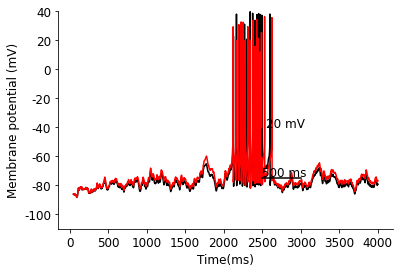

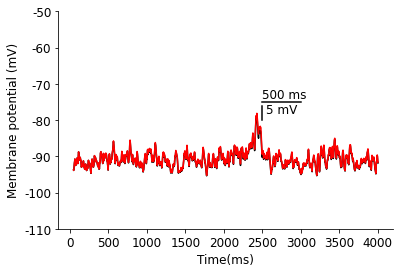

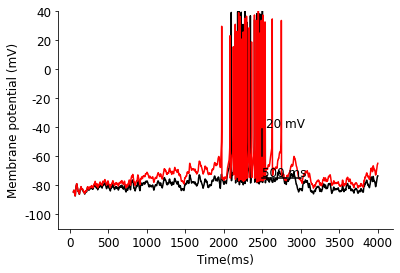

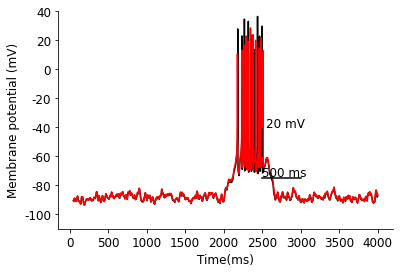

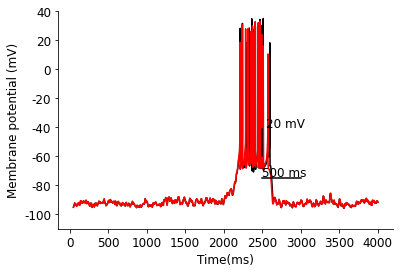

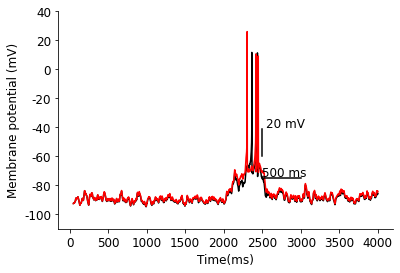

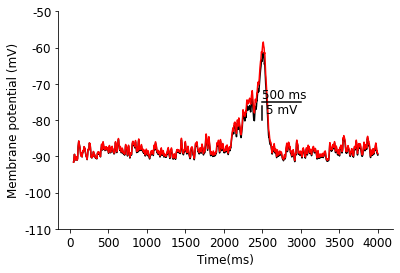

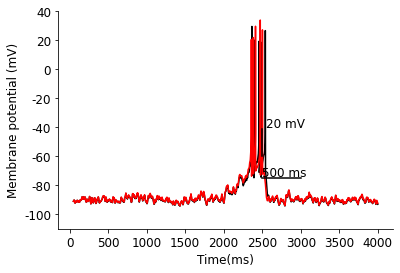

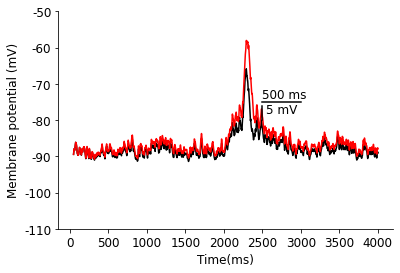

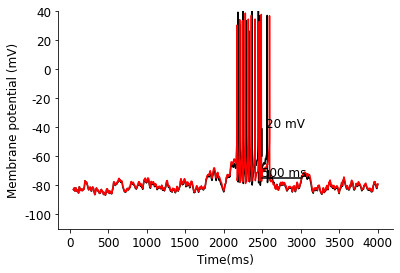

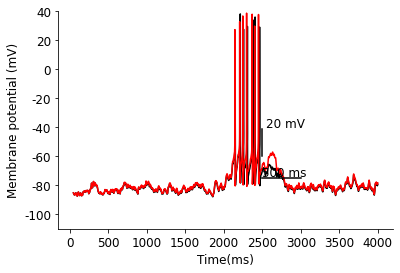

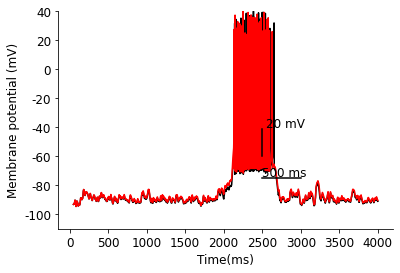

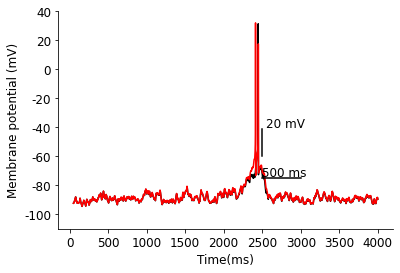

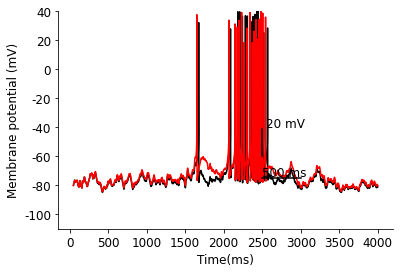

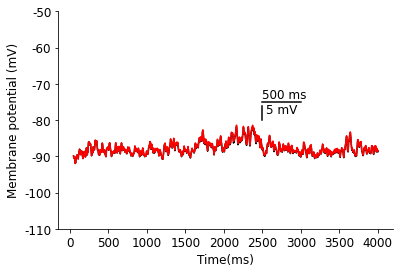

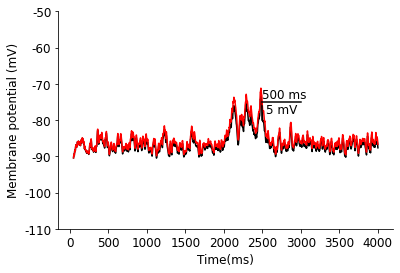

In [21]:
plot_dopamine_control(kl,type_cell='dSPN',traces=25,sub_dir='dSPN-dopamine-all')

/home/jofrony/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/jofrony/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/jofrony/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator


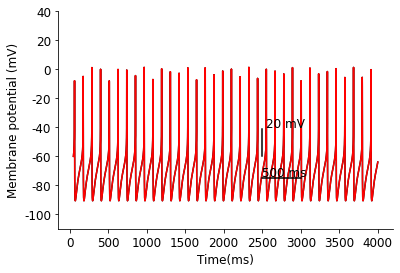

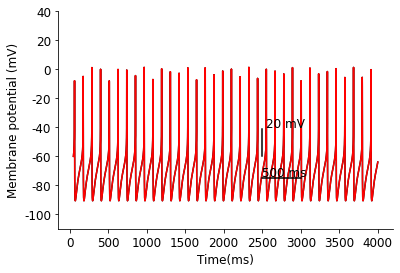

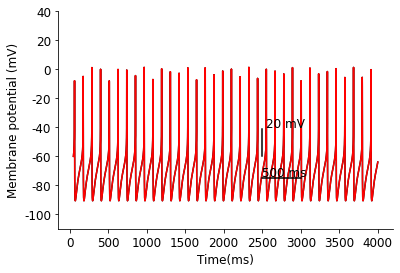

In [22]:
plot_dopamine_control(kl,type_cell='DopaminergicAxon',traces=4,sub_dir='dSPN-dopamine-burst')

In [18]:
import elephant as elp
import neo
import quantities as pq
import numpy as np
import matplotlib.pyplot as plt

def firing_frequency(obj_loaded_traces,type_cell='dSPN'):

    data = obj_loaded_traces.get_traces(neuronType=type_cell)
    data_spikes = dict()
    data_average = dict()
    for ctr, network in data.items():
        data_spikes.update({ctr : dict()})
        data_average.update({ctr : dict()})
        for k, volt in network.items():
            neov = neo.AnalogSignal(volt, units='V',sampling_period = 5e-4 * pq.s)
            spike = elp.spike_train_generation.threshold_detection(neov)
            data_spikes[ctr].update({k : spike})
            
            if len(spike) >0:
                print(max(volt[4000:5000]))
                av = elp.statistics.mean_firing_rate(spike,t_start=2 * pq.s, t_stop= 2.5 *pq.s)
                
                data_average[ctr].update({k : av})
            
    return data_spikes, data_average

def plot_mean_frequency(data_average,labels_v=['V0', 'V1'],exp_title=None,color=['black','red']):
    
    legend_font = {'family' : 'Arial', 'weight' : 'normal', 'size': 12}
    fig, ax = plt.subplots()
    pos = 0
    for k, average in data_average.items():
        ax.bar([pos], [np.array([*average.values()]).mean()],yerr=[np.array([*average.values()]).std()],color=color[k], width=0.4,align='center',capsize=10)
        pos=pos+1
        
    ax.set_ylabel('Mean frequency (Hz)',fontdict=legend_font)
    ax.set_title('Mean frequency (Hz)',fontdict=legend_font)
    ax.set_xticks([*data_average.keys()])
    ax.set_xticklabels(labels_v,fontdict=legend_font,rotation = 90)
    

    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    ylocs, labels = plt.yticks()
    ylocs = [int(k) for k in ylocs]
    ax.set_yticklabels(labels=ylocs,fontdict=legend_font)
    

    ax.figure.set_size_inches(4, 4)
    plt.tight_layout()
    plt.title(exp_title)
    plt.savefig('adaptive/'+exp_title+'_mean_freuquency.svg')
    plt.show()

def percentage_spike(obj_loaded_traces,type_cell='dSPN',total=None):
    
    ratio = dict()
    
    data_dict = obj_loaded_traces.get_traces(neuronType=type_cell)
    for k, data in data_dict.items():
        
        depol = 0
        spike = 0
        
        for t, voltages in data.items():
            if max(voltages)<0:
                depol=depol+1
            else:
                spike=spike+1
                
        ratio.update({k : {'spike': spike, 'pol' : depol, 'percentage': spike/total*100}})
        
    return ratio


def plot_percentage(percentages,chosen=[3,4],labels_v=['control','DA'],c=['black','red'],exp_title='dSPN'):
    fig, ax = plt.subplots()
    legend_font = {'family' : 'Arial', 'weight' : 'normal', 'size': 12}
    pos = 3
    for k, per in percentages.items():
        if k in chosen:
            ax.bar([k], [per['percentage']],align='center',capsize=10,width=0.4,color=c[k])
            
    ax.set_ylabel('Percentage spiking neurons (total) %',fontdict=legend_font)
    ax.set_title('Ratio spike/pol',fontdict=legend_font)
    ax.set_xticks(range(len(chosen)))
    ax.set_xticklabels(labels_v,fontdict=legend_font,rotation = 90)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')


    
    ax.figure.set_size_inches(4, 4)
    plt.tight_layout()
    plt.title(exp_title)
    plt.savefig('adaptive/'+exp_title+'_precentage.svg')
    plt.show()


0.037253100000000004
0.039913800000000006
0.0413548
0.0388921
0.0397318
0.0416624
0.0364969
0.034891599999999995
0.0116762
0.0295937
0.0426265
0.038217799999999996
0.040096200000000005
0.031423
0.040319
0.0378725
0.0389516
0.030891500000000002
0.038489199999999994
0.034187800000000004
0.0404749
0.028544200000000002
0.0333039
0.0260481
0.0339968
0.038836
0.0387599
0.0415745
0.0320395
0.0399959
0.037253100000000004
0.039913800000000006
0.0413548
0.0388921
0.0397318
0.0416624
0.0364969
0.034891599999999995
0.0116762
0.0295937
0.0426265
0.038217799999999996
0.040096200000000005
0.031423
0.040319
0.0374007
0.0279925
0.0098133
0.0330319
0.0306036
0.0241003
0.029963999999999998
0.0357549
0.027443600000000002
-0.0530614
0.031200099999999998
0.0267264
0.0394633
0.037689799999999996
0.0389541
0.0245619
0.0411714


/home/jofrony/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator


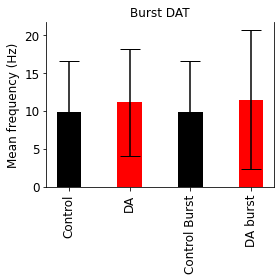

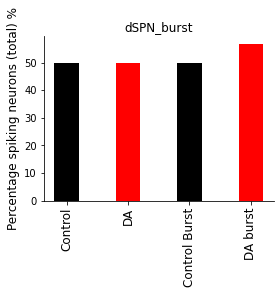

{0: {'spike': 15, 'pol': 10, 'percentage': 50.0},
 1: {'spike': 15, 'pol': 10, 'percentage': 50.0},
 2: {'spike': 15, 'pol': 10, 'percentage': 50.0},
 3: {'spike': 17, 'pol': 8, 'percentage': 56.666666666666664}}

In [19]:
spikes_dSPN, average_dSPN = firing_frequency(kl,type_cell='dSPN')
plot_mean_frequency(average_dSPN,labels_v=['Control', 'DA', 'Control Burst', 'DA burst'],exp_title='Burst DAT',color=['black','red','black','red'])
per_dSPN = percentage_spike(kl,type_cell='dSPN',total=30)
plot_percentage(per_dSPN,exp_title='dSPN_burst',labels_v=['Control', 'DA', 'Control Burst', 'DA burst'],chosen=[0,1,2,3],c=['black','red','black','red'])
per_dSPN

### 